In [1]:
# 1. Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")

Dataset Shape: (284807, 31)

First 5 rows:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.

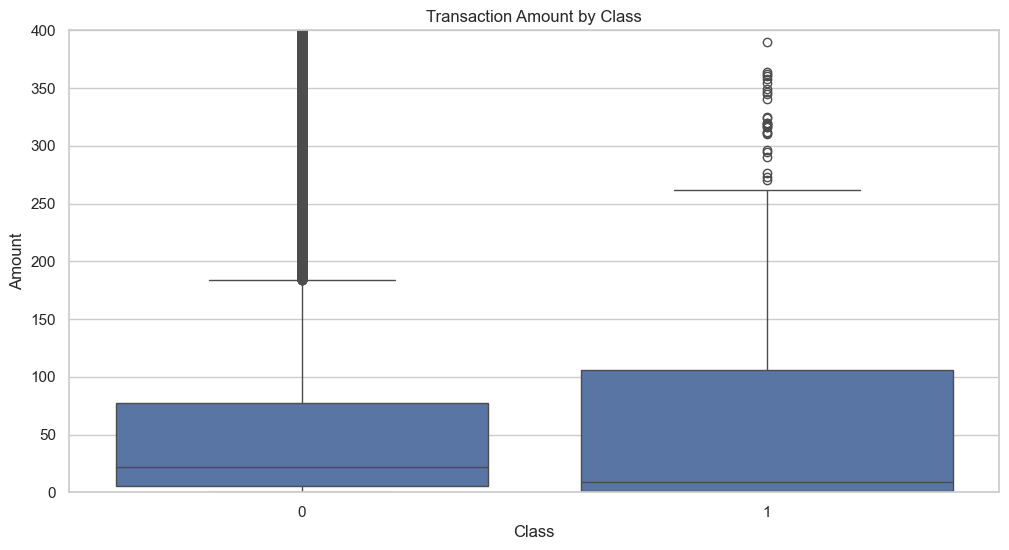

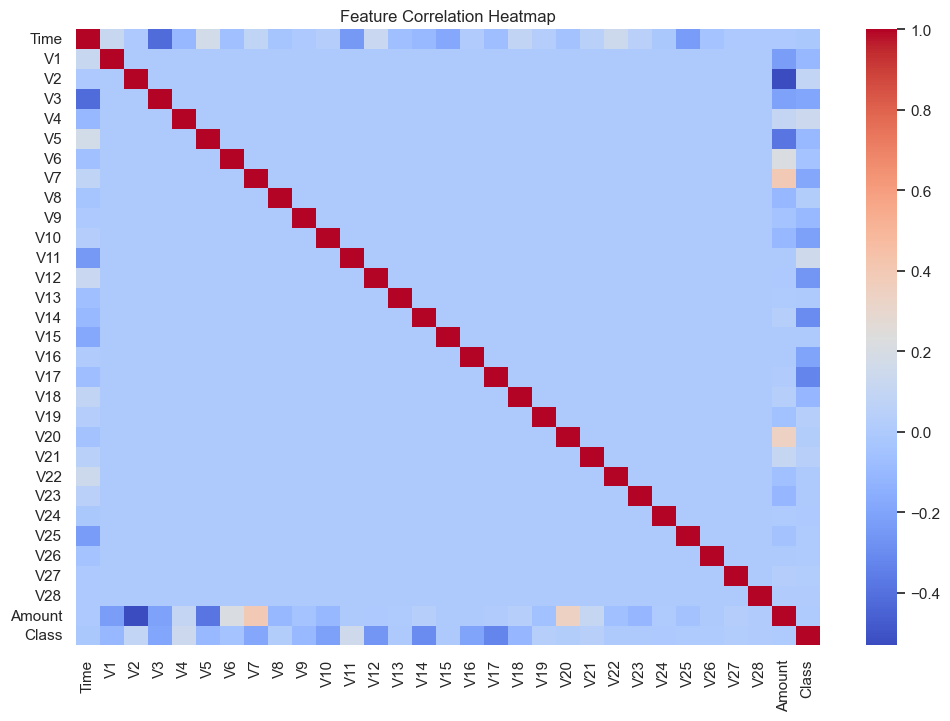

In [2]:
# 2. Load and Explore the Dataset
df = pd.read_csv('creditcard.csv')  # Replace with your file path if needed

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nClass Distribution:")
print(df['Class'].value_counts(normalize=True))  # ~0.17% fraud (Class=1)

# EDA: Amount distribution by class
plt.figure(figsize=(12, 6))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Transaction Amount by Class')
plt.ylim(0, 400)  # Zoom in to see differences
plt.show()

# Correlation with target (frauds often have different patterns in V features)
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

In [3]:
# 3. Data Preprocessing
# Features: Time and Amount need scaling; V1-V28 are already PCA-transformed
X = df.drop('Class', axis=1)
y = df['Class']

# Scale Time and Amount
scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

# Train-test split (stratified to keep imbalance ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
# 4. Handle Class Imbalance
# Option 1: Undersampling majority class (faster on this large dataset)
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

print("After undersampling:")
print(pd.Series(y_train_res).value_counts())

# Option 2: Use class_weight='balanced' in models (no resampling needed – try both!)

After undersampling:
Class
0    394
1    394
Name: count, dtype: int64



Logistic Regression Results:
ROC-AUC: 0.9759546228451987
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.92      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.53     56962
weighted avg       1.00      0.96      0.98     56962



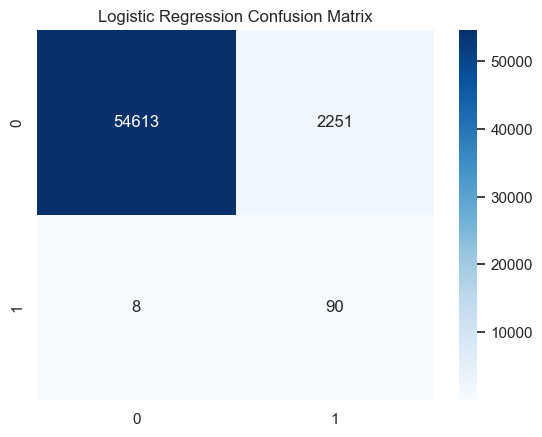

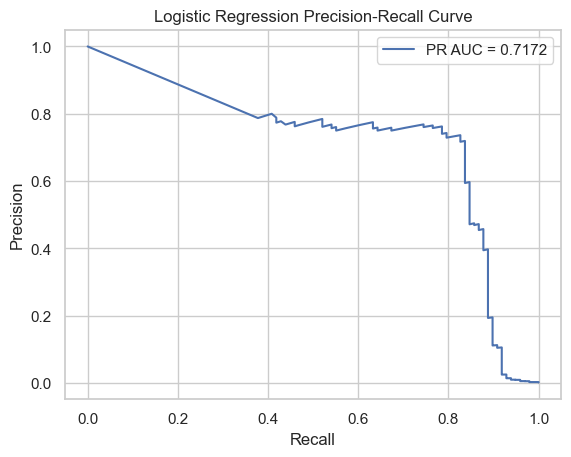


Random Forest Results:
ROC-AUC: 0.9779117629747455
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.92      0.08        98

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.53     56962
weighted avg       1.00      0.96      0.98     56962



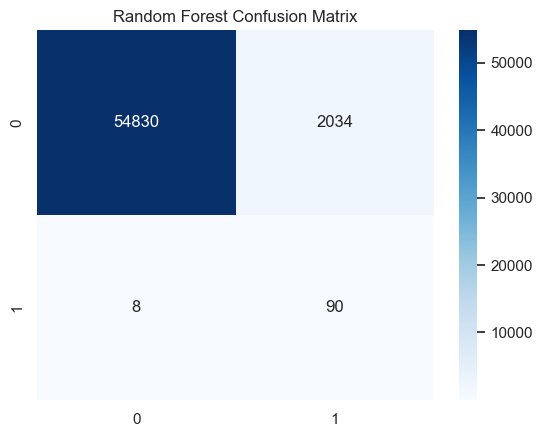

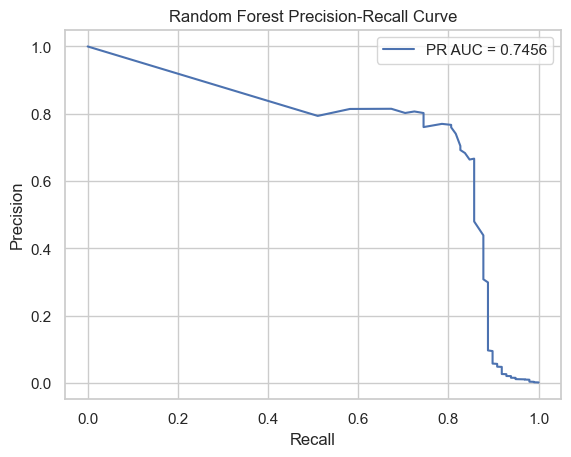


XGBoost Results:
ROC-AUC: 0.979753159705075
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95     56864
           1       0.02      0.92      0.03        98

    accuracy                           0.91     56962
   macro avg       0.51      0.91      0.49     56962
weighted avg       1.00      0.91      0.95     56962



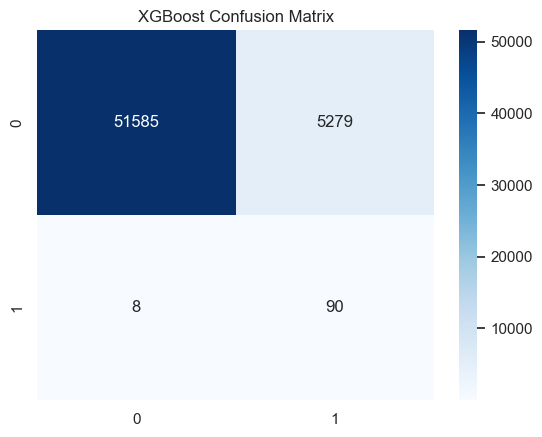

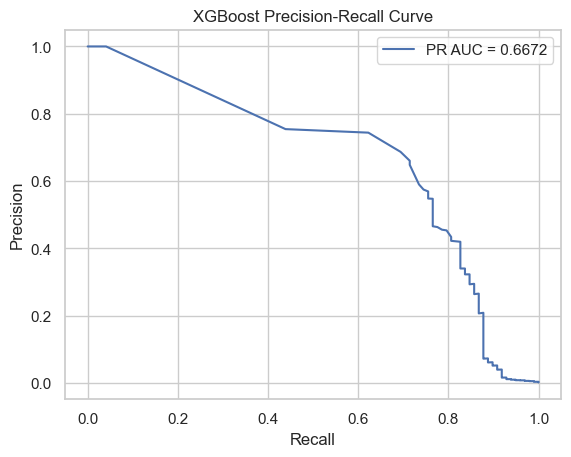

In [5]:
# 5. Model Training and Evaluation
# We'll train 3 models: Logistic Regression (baseline), Random Forest, XGBoost

def evaluate_model(model, X_test, y_test, name):
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    
    print(f"\n{name} Results:")
    print("ROC-AUC:", roc_auc_score(y_test, probs))
    print("Classification Report:\n", classification_report(y_test, preds))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.show()
    
    # Precision-Recall Curve (better for imbalance)
    precision, recall, _ = precision_recall_curve(y_test, probs)
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{name} Precision-Recall Curve')
    plt.legend()
    plt.show()

# Logistic Regression (fast baseline)
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train_res, y_train_res)
evaluate_model(lr, X_test, y_test, "Logistic Regression")

# Random Forest
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train_res, y_train_res)
evaluate_model(rf, X_test, y_test, "Random Forest")

# XGBoost (often best here – install with !pip install xgboost if needed)
xgb = XGBClassifier(scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train), random_state=42)
xgb.fit(X_train_res, y_train_res)
evaluate_model(xgb, X_test, y_test, "XGBoost")

In [6]:
from sklearn.model_selection import cross_val_score

# Example with XGBoost on undersampled data (or full data with scale_pos_weight)
cv_scores = cross_val_score(xgb, X_train_res, y_train_res, cv=5, scoring='roc_auc')
print("Cross-validation ROC-AUC scores:", cv_scores)
print("Mean CV ROC-AUC:", cv_scores.mean())

Cross-validation ROC-AUC scores: [0.96170485 0.99022593 0.97804839 0.97419669 0.99042519]
Mean CV ROC-AUC: 0.9789202092038177


In [7]:
# Example: Predict on first 5 test samples
sample_preds = xgb.predict(X_test.iloc[:5])
sample_probs = xgb.predict_proba(X_test.iloc[:5])[:, 1]
print("Actual labels:", y_test.iloc[:5].values)
print("Predicted labels:", sample_preds)
print("Fraud probabilities:", sample_probs)

Actual labels: [0 0 0 0 0]
Predicted labels: [0 0 1 0 1]
Fraud probabilities: [3.8972357e-03 3.0432497e-03 9.7762680e-01 4.5543216e-05 9.9998319e-01]


In [8]:
from sklearn.metrics import precision_recall_fscore_support

# Get probabilities
y_probs = xgb.predict_proba(X_test)[:, 1]

# Try different thresholds
thresholds = [0.3, 0.5, 0.7]
for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_thresh, average='binary')
    print(f"\nThreshold {thresh}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")


Threshold 0.3: Precision=0.0139, Recall=0.9286, F1=0.0275

Threshold 0.5: Precision=0.0168, Recall=0.9184, F1=0.0329

Threshold 0.7: Precision=0.0202, Recall=0.9184, F1=0.0396


In [9]:
# Sort by Time and split chronologically
df_sorted = df.sort_values('Time')
split_idx = int(0.8 * len(df_sorted))
train = df_sorted.iloc[:split_idx]
test = df_sorted.iloc[split_idx:]
# Then preprocess and train/test as before

In [10]:
import joblib

# Save best model (e.g., XGBoost)
joblib.dump(xgb, 'best_fraud_model.pkl')

# Later: Load and test on new data
loaded_model = joblib.load('best_fraud_model.pkl')
# Apply same scaling and predict